In [2]:
# #only run once
# #!pip install nes-py==0.2.6
# !brew update
# !brew install ffmpeg
# !brew install libsm
# !brew install libxext
# !brew install mesa
# !pip install opencv-python
# !pip install gym-super-mario-bros
# !pip install gym

In [3]:
import torch
import torch.nn as nn
import random
import gym
import gym_super_mario_bros
from nes_py.wrappers import JoypadSpace
from gym_super_mario_bros import SuperMarioBrosEnv
from tqdm import tqdm
import pickle 
import gym
import numpy as np
import collections 
import cv2
import matplotlib.pyplot as plt
import time
import datetime
import json
from toolkit.gym_env import *
from toolkit.action_utils import *
from toolkit.marlios_model import *
from toolkit.constants import *
import warnings

warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2

In [4]:
def show_state(env, ep=0, info=""):
    plt.figure(3)
    plt.clf()
    plt.imshow(env.render(mode='rgb_array'))
    plt.title("Episode: %d %s" % (ep, info))
    plt.axis('off')

    # display.clear_output(wait=True)
    # display.display(plt.gcf())
    display(plt.gcf(), clear=True)

def make_env(env, actions=ACTION_SPACE):
    env = MaxAndSkipEnv(env, skip=2) # I am testing out fewer fram repetitions for our two actions modelling
    env = ProcessFrame84(env)
    env = ImageToPyTorch(env)
    env = BufferWrapper(env, 4)
    env = ScaledFloatFrame(env)
    return JoypadSpace(env, actions)

def generate_epoch_time_id():
    epoch_time = int(time.time())
    return str(epoch_time)

def save_checkpoint(agent, total_rewards, terminal_info, run_id):
    with open(f"ending_position-{run_id}.pkl", "wb") as f:
        pickle.dump(agent.ending_position, f)
    with open(f"num_in_queue-{run_id}.pkl", "wb") as f:
        pickle.dump(agent.num_in_queue, f)
    with open(f"total_rewards-{run_id}.pkl", "wb") as f:
        pickle.dump(total_rewards, f)
    with open(f"terminal_info-{run_id}.pkl", "wb") as f:
        pickle.dump(terminal_info, f)
    if agent.double_dq:
        torch.save(agent.local_net.state_dict(), f"dq1-{run_id}.pt")
        torch.save(agent.target_net.state_dict(), f"dq2-{run_id}.pt")
    else:
        torch.save(agent.dqn.state_dict(), f"dq-{run_id}.pt")  

def load_rewards(from_file):
     with open(from_file, 'rb') as f:
        total_rewards = pickle.load(f)
        return total_rewards

def load_loss(from_file):
     with open(from_file, 'rb') as f:
        total_loss = pickle.load(f)
        return total_loss

def plot_loss(ep_per_stat = 100, total_loss = [], from_file = None):
    if from_file != None:
        total_loss = load_loss(from_file)
       
    # avg_loss = [np.mean(total_loss[i:i+ep_per_stat]) for i in range(0, len(total_loss), ep_per_stat)]
    # std_loss = [np.std(total_loss[i:i+ep_per_stat]) for i in range(0, len(total_loss), ep_per_stat)]

    fig, ax = plt.subplots()
    # ax.plot(avg_loss, label='Average loss')
    ax.plot(total_loss, label='Loss')
    # ax.fill_between(range(len(avg_loss)), np.subtract(avg_loss, std_loss), np.add(avg_loss, std_loss), alpha=0.2, label='Reward StdDev')

    ax.set_xlabel('Episode')
    ax.set_ylabel('Loss')
    xtick_labels = [str(i*ep_per_stat) for i in range(len(total_loss) // ep_per_stat + 1)]
    plt.xticks(range(0, len(total_loss), ep_per_stat), xtick_labels)
    ax.legend(loc='lower right')
    plt.show()

def plot_rewards(ep_per_stat = 100, total_rewards = [], from_file = None, tick_freq = 2):
    if from_file != None:
        total_rewards = load_rewards(from_file)

    total_rewards = total_rewards[:len(total_rewards) - 2]
       
    avg_rewards = [np.mean(total_rewards[i:i+ep_per_stat]) for i in range(0, len(total_rewards), ep_per_stat)]
    std_rewards = [np.std(total_rewards[i:i+ep_per_stat]) for i in range(0, len(total_rewards), ep_per_stat)]

    fig, ax = plt.subplots()
    ax.plot(avg_rewards, label='Average Rewards')
    ax.fill_between(range(len(avg_rewards)), np.subtract(avg_rewards, std_rewards), np.add(avg_rewards, std_rewards), alpha=0.2, label='Reward StdDev')

    ax.set_xlabel('Episode')
    ax.set_ylabel('Reward')
    xtick_labels = [str(i*ep_per_stat) for i in range(0, len(avg_rewards), tick_freq)]
    plt.xticks(range(0, len(avg_rewards), tick_freq), xtick_labels)
    plt.xticks(rotation=45)
    fig.suptitle("Average Rewards per Episode for MaRLios Model", fontsize=13, fontweight="bold")
    ax.set_title("Avg. and Std. Dev per 100 episodes", fontsize=11, pad=16, y=0.97)
    
    ax.legend(loc='lower right')
    plt.show()

# define the run function with some helpful debugging stats

def run(training_mode=True, pretrained=False, lr=0.0001, gamma=0.90, exploration_decay=0.995, exploration_min=0.02, 
        ep_per_stat = 100, exploration_max = 1, sample_actions = True,
        mario_env='SuperMarioBros-1-1-v0', action_space=TWO_ACTIONS_SET, num_episodes=1000, run_id=None, n_actions=5):
   
    run_id = run_id or generate_epoch_time_id()
    fh = open(f'progress-{run_id}.txt', 'a')
    env = gym.make(mario_env)
    env = make_env(env, ACTION_SPACE)


    # observation_space = env.observation_space.shape # not using this anymore

    #todo: add agent params as a setting/create different agents in diff functions to run 
    exploration_max = min(1, max(exploration_max, exploration_min))

    agent = DQNAgent(
                     state_space=env.observation_space.shape,
                     action_space=action_space,
                     max_memory_size=30000,
                     batch_size=64,
                     gamma=gamma,
                     lr=lr,
                     dropout=None,
                     exploration_max=exploration_max,
                     exploration_min=exploration_min,
                     exploration_decay=exploration_decay,
                     double_dq=True,
                     pretrained=pretrained,
                     run_id=run_id,
                     n_actions=n_actions,
                     sample_actions = sample_actions)
    
    
    # num_episodes = 10
    env.reset()
    total_rewards = []
    total_info = []
    total_loss = []

    if pretrained:
        total_rewards = load_rewards(from_file='total_rewards-{}.pkl'.format(run_id))
        # total_loss = load_loss(from_file='total_loss-{}.pkl'.format(run_id))
    
    offset = len(total_rewards)   
    for iteration in tqdm(range(num_episodes)):
        ep_num = offset + iteration

        state = env.reset() # take the final dimension of shape 
        state = torch.Tensor([state])# converts (1, 84, 84) to (1, 1, 84, 84)
        total_reward = 0
        steps = 0

        action_freq = {}
        while True:
            if not training_mode:
                show_state(env, ep_num)


            two_actions_index = agent.act(state)
            two_actions_vector = agent.cur_action_space[0, two_actions_index[0]]
            two_actions = vec_to_action(two_actions_vector.cpu()) # tuple of actions

            # debugging info
            key = " | ".join([",".join(i) for i in two_actions])
            if key in action_freq:
                action_freq[key] += 1
            else:
                action_freq[key] = 1
            
            steps += 1
            reward = 0
            info = None
            terminal = False
            for action in two_actions: 
                if not terminal:
                    # compute index into ACTION_SPACE of our action
                    step_action = ACTION_TO_INDEX[action]

                    state_next, cur_reward, terminal, info = env.step(step_action)
                    total_reward += cur_reward
                    reward += cur_reward
                    
            state_next = torch.Tensor([state_next])
            reward = torch.tensor([reward]).unsqueeze(0)        
            terminal = torch.tensor([int(terminal)]).unsqueeze(0)
            
            if training_mode:
                agent.remember(state, two_actions_index, reward, state_next, terminal)
                replay_result = agent.experience_replay(debug=True)
                if replay_result is not None:
                    _, _, loss = replay_result
                    total_loss.append(loss.mean().item())

            
            state = state_next
            if terminal:
                break

        total_info.append(info)
        total_rewards.append(total_reward)

        if training_mode and (ep_num % ep_per_stat) == 0 and ep_num != 0:
            save_checkpoint(agent, total_rewards, total_info, total_loss, run_id)

        with open(f'total_reward-{run_id}.txt', 'a') as f:
            f.write("Total reward after episode {} is {}\n".format(ep_num + 1, total_rewards[-1]))
            if (ep_num%100 == 0):
                f.write("==================\n")
                f.write("{} current time at episode {}\n".format(datetime.datetime.now(), ep_num+1))
                f.write("==================\n")
            #print("Total reward after episode {} is {}".format(ep_num + 1, total_rewards[-1]))
            num_episodes += 1
        
        with open(f'actions_chosen-{run_id}.txt', 'a') as f:
            f.write("Action Frequencies for Episode {}, Exploration = {:4f}\n".format(ep_num + 1, agent.exploration_rate))
            f.write(json.dumps(action_freq) + "\n\n")
    
    if training_mode:
        save_checkpoint(agent, total_rewards, total_info, total_loss, run_id)
    
    env.close()
    fh.close()
    
    if num_episodes > ep_per_stat:
        plot_rewards(ep_per_stat=ep_per_stat, total_rewards=total_rewards)


In [ ]:
# rerunning fresh

run(training_mode=True, 
    pretrained=False, # use the pretrained model
    ep_per_stat=100, 
    num_episodes=10,
    run_id='test',
    lr=0.00001,
    exploration_min=0.02,
    exploration_max = 1, # setting this to the min for the rerun model
    exploration_decay=0.9995, 
    action_space=SIMPLE_MOVEMENT,
    n_actions=len(SIMPLE_MOVEMENT)+2)

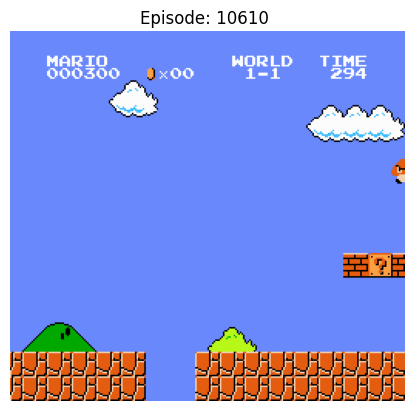

100%|██████████| 10/10 [07:57<00:00, 47.72s/it]


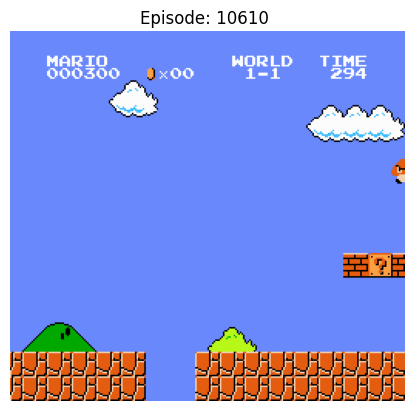

In [8]:
# Run with pretrained model

run(training_mode=False, 
    pretrained=True, # use the pretrained model
    ep_per_stat=100, 
    num_episodes=10,
    run_id='marlios_run_two_action_set_lr_0_0001',
    lr=0.00001,
    exploration_min=0.02,
    exploration_max = 0.02, # setting this to the min for the rerun model
    exploration_decay=0.9995, 
    action_space=TWO_ACTIONS_SET,
    n_actions=26,
    sample_actions = True)
    # action_space=SIMPLE_MOVEMENT,
    # n_actions=len(SIMPLE_MOVEMENT),
    # sample_actions = False)

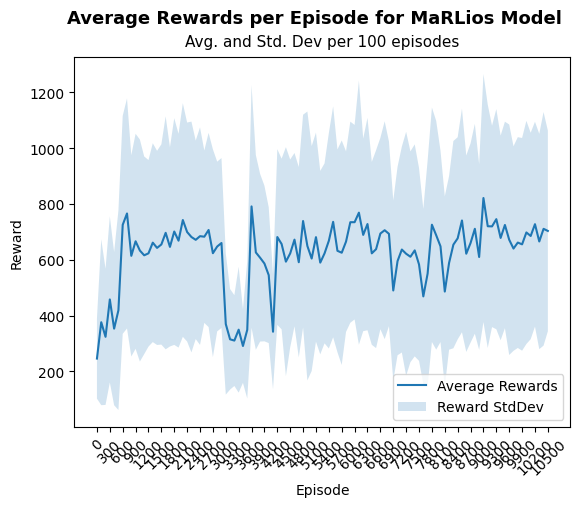

In [7]:
plot_rewards(ep_per_stat=100, from_file='./total_rewards-marlios_run_two_action_set_lr_0_0001.pkl', tick_freq=3)

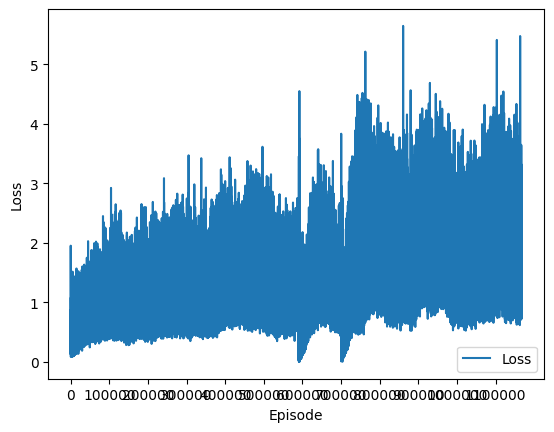

In [98]:
plot_loss(ep_per_stat=100000, from_file='./total_loss-marlios_run_two_action_set_lr_0_0001.pkl')

# Debugging

In [14]:
x = torch.randn(2, 3, 5)
reshaped_input = x.view(-1, x.shape[-1])
final = reshaped_input.view(x.shape[0], x.shape[1], -1)


In [15]:
print(x)
print(reshaped_input)
print(final)

tensor([[[-0.3939,  0.9087,  0.0522, -0.7961,  0.2194],
         [-2.1833, -0.5012, -1.5120,  1.1976, -1.4270],
         [-1.4877,  0.4767,  0.2844,  0.6696, -0.1502]],

        [[ 0.9327,  2.3834, -0.3934,  0.6228,  0.9853],
         [-0.8383,  0.4333,  0.4330, -0.3917,  0.4475],
         [ 1.0167, -0.6274, -1.3792, -0.0133, -1.2329]]])
tensor([[-0.3939,  0.9087,  0.0522, -0.7961,  0.2194],
        [-2.1833, -0.5012, -1.5120,  1.1976, -1.4270],
        [-1.4877,  0.4767,  0.2844,  0.6696, -0.1502],
        [ 0.9327,  2.3834, -0.3934,  0.6228,  0.9853],
        [-0.8383,  0.4333,  0.4330, -0.3917,  0.4475],
        [ 1.0167, -0.6274, -1.3792, -0.0133, -1.2329]])
tensor([[[-0.3939,  0.9087,  0.0522, -0.7961,  0.2194],
         [-2.1833, -0.5012, -1.5120,  1.1976, -1.4270],
         [-1.4877,  0.4767,  0.2844,  0.6696, -0.1502]],

        [[ 0.9327,  2.3834, -0.3934,  0.6228,  0.9853],
         [-0.8383,  0.4333,  0.4330, -0.3917,  0.4475],
         [ 1.0167, -0.6274, -1.3792, -0.0133, -

In [22]:
loss = load_loss('./total_loss-marlios_run_no_sample_lr_0_0001.pkl')

In [27]:
len(loss)
loss[0:30]


[5.141533851623535,
 4.460992813110352,
 5.295253276824951,
 4.35986328125,
 4.543642997741699,
 4.190987586975098,
 4.922931671142578,
 4.466704368591309,
 4.584052562713623,
 4.102752685546875,
 4.795726776123047,
 3.8813600540161133,
 3.81713604927063,
 3.7155098915100098,
 3.357593536376953,
 4.106273174285889,
 3.3816332817077637,
 3.2348928451538086,
 3.6818108558654785,
 3.72611927986145,
 3.2683355808258057,
 3.420872688293457,
 3.653456211090088,
 3.613271713256836,
 3.689671516418457,
 3.6937150955200195,
 3.4634366035461426,
 3.5722179412841797,
 3.4611191749572754,
 3.5614728927612305]